# Tree Ensembles and Random Forests - Lab

## Introduction

In this lab, we'll create some popular Tree Ensemble models such as a Bag of Trees and a Random Forest to predict a person's salary based on information about them. 

## Objectives

You will be able to:

* Create, train, and make predictions with Bagging Classifiers
* Create, train, and make predictions with a Random Forest
* Understand and explain the concept of bagging as it applies to Ensemble Methods
* Understand and explain the Subspace Sampling Method and it's use in Random Forests

## 1. Importing the data

In this lab, we'll be looking at a dataset of information about people and trying to predict if they make more than 50k/year.  The salary data set was extracted from the census bureau database and contains salary information. The goal is to use this data set and to try to draw conclusions regarding what drives salaries. More specifically, the target variable is categorical (> 50k; <= 50 k). Let's create a classification tree!

To get started, run the cell below to import everything we'll need for this lab. 

In [58]:
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

Our dataset is stored in the file `salaries_final.csv`.  

In the cell below, read in the dataset from this file and store it in a DataFrame.  Be sure to set the `index_col` parameter to `0`.  Then, display the head of the DataFrame to ensure that everything loaded correctly.

In [59]:
salaries = pd.read_csv('salaries_final.csv')
salaries.head(2)

,Unnamed: 0,Age,Education,Occupation,Relationship,Race,Sex,Target
0,0,39,Bachelors,Adm-clerical,Not-in-family,White,Male,<=50K
1,1,50,Bachelors,Exec-managerial,Husband,White,Male,<=50K


In total, there are 6 predictors, and one outcome variable, the target salary <= 50k/ >50k.

recall that the 6 predictors are:

- `Age`: continuous.

- `Education`: Categorical. Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, 
Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.

- `Occupation`: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.

- `Relationship`: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.

- `Race`: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.

- `Sex`: Female, Male.

First, we'll need to store our `'Target'` column in a separate variable and drop it from the dataset.  

Do this in the cell below. 

In [60]:
for col in salaries:
    cat_count = len(salaries[col].value_counts())
    if cat_count < 20:
        print(col, 'has', cat_count)

Education has 16
Occupation has 15
Relationship has 6
Race has 5
Sex has 2
Target has 2


In [61]:
target = salaries['Target'].replace({'<=50K': 0, '>50K': 1})

Next, we'll want to confirm that the Age column is currently encoded in a numeric data type, and not a string. By default, pandas will treat all columns encoded as strings as categorical columns, and create a dummy column for each unique value contained within that column.  We do not want a separate column for each age, so let's double check that the age column is encoded as an integer or a float.  

In the cell below, check the `.dtypes` of the DataFrame to examine the data type of each column. 

In [62]:
salaries.columns

Index(['Unnamed: 0', 'Age', 'Education', 'Occupation', 'Relationship', 'Race',
       'Sex', 'Target'],
      dtype='object')

Great.  Now we're ready to create some dummy columns and deal with our categorical variables.  

In the cell below, use pandas to create dummy columns for each of categorical variables.  If you're unsure of how to do this, check out the [documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html).  

In [63]:
data = salaries[['Age', 'Education', 'Occupation', 'Relationship', 'Race', 'Sex']]
data.head()

,Age,Education,Occupation,Relationship,Race,Sex
0,39,Bachelors,Adm-clerical,Not-in-family,White,Male
1,50,Bachelors,Exec-managerial,Husband,White,Male
2,38,HS-grad,Handlers-cleaners,Not-in-family,White,Male
3,53,11th,Handlers-cleaners,Husband,Black,Male
4,28,Bachelors,Prof-specialty,Wife,Black,Female


Now, split your data and target into training and testing sets using the appropriate method from sklearn. 

In [64]:
data_train, data_test, target_train, target_test = train_test_split(data, target)

## 2. Let's rebuild a "regular" tree as a baseline

We'll begin by fitting a regular Decision Tree Classifier, so that we have something to compare our ensemble methods to.  

### 2.1 Building the tree

In the cell below, create a Decision Tree Classifier.  Set the `criterion` to `'gini'`, and a `max_depth` of `5`.  Then, fit the tree to our training data and labels.  

In [65]:
!pip install sklearn-pandas
from sklearn.preprocessing import OneHotEncoder
import sklearn_pandas as skp

You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [105]:
'''
This "gen_features" just builds a properly formatted list to pass in to skp.DataFrameMapper()
when we want to apply the same function to multiple columns.

OneHotEncoder needs df, not series, so we pass a list of single item lists.
'''
define_features = skp.gen_features(
    columns=[['Education'], ['Occupation'], ['Relationship'], ['Race'], ['Sex']],  
    classes=[OneHotEncoder]
)


'''
The commented out top line will do nothing to "Age" but importantly, it WILL keep it in 
the front column of df_out. This is also possible by passing in the "default=None" parameter
which is different from the default behaviour: "default=False". (Although the "Age" column will 
be the final column instead of the front using the parameter option.) 
'''
one_hot_map = skp.DataFrameMapper(
    #[('Age', None)] +
    define_features,
    df_out=True, default=None)

data_train_out = one_hot_map.fit_transform(data_train)
data_train_out.shape

(24420, 45)

In [110]:
transformer = skp.pipeline.TransformerPipeline([
    ('one hot', one_hot_map)
])

In [119]:
tree_clf = DecisionTreeClassifier(criterion='gini', )

pipe = skp.pipeline.Pipeline([
    ('one hot', transformer),
    ('model', tree_clf)
])

In [126]:
pipe.fit(data_train, y=target_train)

Pipeline(memory=None,
     steps=[('one hot', TransformerPipeline(steps=[('one hot', DataFrameMapper(default=None, df_out=True,
        features=[(['Education'], [OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=True)]), (['Occ...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

In [127]:
pipe.score(data_test, target_test)

0.7957253408672154

### 2.1 Feature importance

Let's quickly examine how important each feature ended up being in our Decision Tree model.  Check the `feature_importances_` attribute of our trained model to see what it displays. 

In [122]:
model = pipe.named_steps['model']

That matrix isn't very helpful, but a visualization of the data it contains could be.  Run the cell below to plot a visualization of the feature importances for this model. Run the cell below to create a visualization of the data stored inside of a model's `.feature_importances_` attribute.

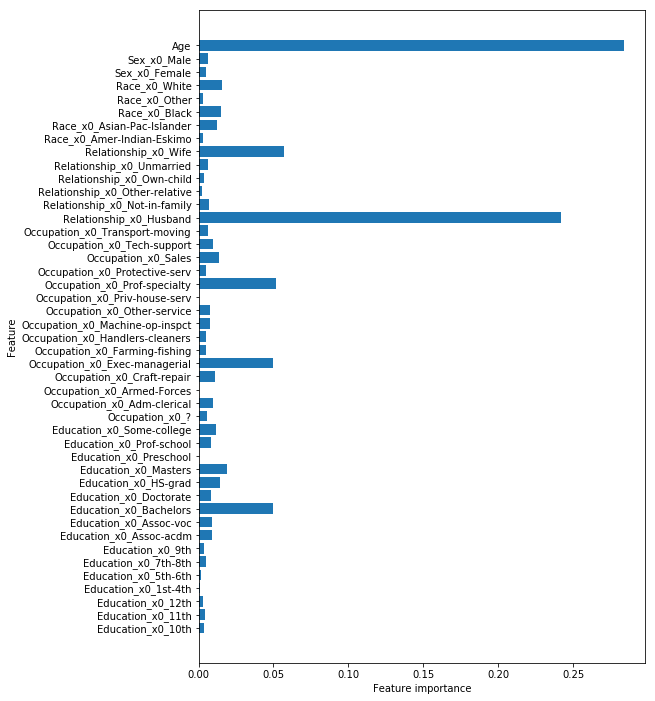

In [123]:
def plot_feature_importances(model):
    plt.figure(figsize=(8,12))
    plt.barh(range(model.n_features_), model.feature_importances_, align='center') 
    plt.yticks(np.arange(model.n_features_), data_train_out.columns) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances(model)

### 2.3 Model performance

Next, let's see how well our model performed on the data. 

In the cell below:

* Use the classifier to create predictions on our test set. 
* Print out a `confusion_matrix` of our test set predictions.
* Print out a `classification_report` of our test set predictions.

In [129]:
pred = pipe.predict(data_test)

Now, let's check the model's accuracy. Run the cell below to display the test set accuracy of the model. 

In [130]:
print("Testing Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(target_test, pred) * 100))

Testing Accuracy for Decision Tree Classifier: 79.57%


## 3. Bagged trees

The first Ensemble approach we'll try is a Bag of Trees.  This will make use of **_Bagging_**, along with a number of Decision Tree Classifier models.  

Now, let's create a `BaggingClassifier`.  In the first parameter spot, initialize a `DecisionTreeClassifier` and set the same parameters that we did above for `criterion` and `max_depth`.  Also set the `n_estimators` parameter for our Bagging Classifier to `20`. 

In [ ]:
bagged_tree = BaggingClassifier()

Great! Now, fit it to our training data. 

Checking the accuracy of a model is such a common task that all (supervised learning) models contain a `score()` method that wraps the `accuracy_score` helper method we've been using.  All we have to do is pass it a dataset and the corresponding labels and it will return the accuracy score for those data/labels.  

Let's use it to get the training accuracy of our model. In the cell below, call the `.score()` method on our Bagging model and pass in our training data and training labels as parameters. 

Now, let's check the accuracy score that really matters--our testing accuracy.  This time, pass in our testing data and labels to see how the model did.  

## 4. Random forests

Another popular ensemble method is the **_Random Forest_** model.  Let's fit a Random Forest Classifier next and see how it measures up compared to all the others. 

### 4.1 Fitting a random forests model

In the cell below, create a `RandomForestClassifier`, and set the number estimators to `100` and the max depth to `5`. Then, fit the model to our training data. 

In [ ]:
forest = None

Now, let's check the training and testing accuracy of the model using its `.score()` method.

### 4.2 Look at the feature importances

In [ ]:
plot_feature_importances(forest)

Note: "relationship" represents what this individual is relative to others. For example an
individual could be a Husband. Each entry only has one relationship, so it is a bit of a weird attribute.

Also note that more features show up. This is a pretty typical result. 

### 4.3 Look at the trees in your forest

Let's create a forest with some small trees. You'll learn how to access trees in your forest!

In the cell below, create another `RandomForestClassifier`.  Set the number of estimators to 5, the `max_features` to 10, and the `max_depth` to 2.

In [ ]:
forest_2 = None


Making `max_features` smaller will lead to very different trees in your forest!

The trees in your forest are stored in the `.estimators_` attribute.

In the cell below, get the first tree from `forest_2.estimators_` and store it in `rf_tree_1`

In [ ]:
rf_tree_1 = None

Now, we can reuse ourn `plot_feature_importances` function to visualize which features this tree was given to use duing subspace sampling. 

In the cell below, call `plot_feature_importances` on `rf_tree_1`.

Now, grab the second tree and store it in `rf_tree_2`, and then pass it to `plot_feature_importances` in the following cell so we can compare which features were most useful to each. 

In [ ]:
rf_tree_2 = None

We can see by comparing the two plots that the two trees we examined from our Random Forest look at different attributes, and have wildly different importances for them!

## Summary

In this lab, we got some practice creating a few different Tree Ensemble Methods. We also learned how to visualize feature importances, and compared individual trees from a Random Forest to see if we could notice the differences in the features they were trained on. 